# Setup
> Note: Colab only

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp -r /content/drive/MyDrive/Capstone/Eye-Infection-Dataset/ -t .
!mv ./Eye-Infection-Dataset ./dataset
!rm ./dataset/LICENSE.md

# Data Processing

In [3]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from io import BytesIO
from ipywidgets import widgets
from google.colab import files

In [47]:
DATASET_PATH = './dataset'
CLASSES = sorted(os.listdir(DATASET_PATH))
IMAGE_SIZE=(150, 150)

['normal', 'stye', 'uveitis']


In [13]:
train_ds, val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_PATH,
    image_size=IMAGE_SIZE,
    label_mode='categorical',
    validation_split=0.2,
    subset='both',
    batch_size=32,
    seed=8
)

Found 615 files belonging to 3 classes.
Using 492 files for training.
Using 123 files for validation.


In [14]:
train_ds_pref = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds_pref = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

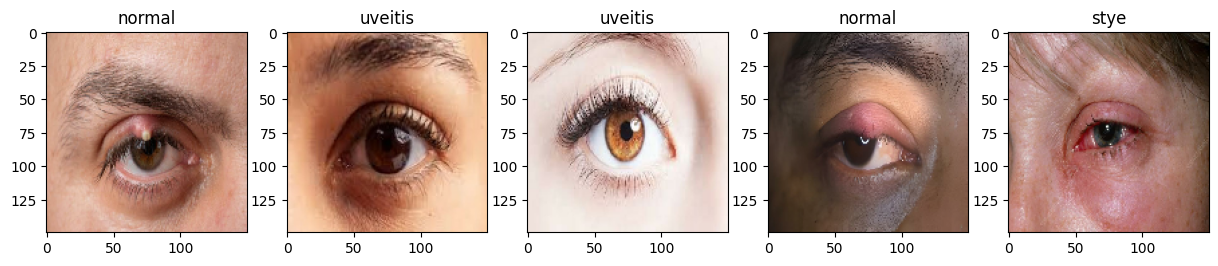

In [15]:
imgs = list(train_ds.take(5))[0]

# print(imgs)

plot, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 15))

for i, ax in enumerate(axes):
  img = tf.keras.utils.array_to_img(imgs[0][i])
  lbl = CLASSES[np.argmax(imgs[1][i].numpy())]

  ax.title.set_text(lbl)
  ax.imshow(img)

# Model Setup

In [27]:
class CustomCallback(tf.keras.callbacks.Callback):
  def __init__(self):
    super(CustomCallback, self).__init__()
    self.prev_acc = 0.0

  def on_epoch_end(self, epoch, logs=None):
    self.prev_acc = logs['accuracy']

    # Early stop when there is no accuracy or loss improvement
    if epoch > 10 and self.prev_acc < 0.5:
      self.model.stop_training = True
      print("\nStopped the training because there is no improvement")

    # Early stop when the model has achieved the desired accuracy
    if logs['accuracy'] >= 0.92 and logs['val_accuracy'] >= 0.9:
      self.model.stop_training = True
      print("\nAlready met the desired accuracy")

# Model Training

In [28]:
tf.keras.backend.clear_session()

In [29]:
model_aug = tf.keras.models.Sequential([
    tf.keras.Input(shape=IMAGE_SIZE + (3,)),
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.1),
])

In [30]:
model = tf.keras.models.Sequential([
    model_aug,
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.UpSampling2D(2),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Conv2D(256, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Conv2D(256, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax'),
])

In [31]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1E-4),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

model.fit(
    train_ds,
    epochs=100,
    batch_size=16,
    validation_data=val_ds,
    callbacks=[CustomCallback()]
)

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 0.3222 - loss: 1.0905 - val_accuracy: 0.4065 - val_loss: 1.0586
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.4122 - loss: 1.0716 - val_accuracy: 0.4390 - val_loss: 1.0466
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.4429 - loss: 1.0700 - val_accuracy: 0.4959 - val_loss: 1.0284
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.4639 - loss: 1.0570 - val_accuracy: 0.4472 - val_loss: 1.0147
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.4939 - loss: 1.0193 - val_accuracy: 0.4959 - val_loss: 0.9630
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.5099 - loss: 0.9666 - val_accuracy: 0.5285 - val_loss: 0.8983
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.5668 - loss: 0.8845 - val_accuracy: 0.5041 - val_loss: 0.9521
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.5285 - loss: 0.9582 - val_accuracy: 0

# Model Evaluation

In [32]:
model.evaluate(val_ds)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9206 - loss: 0.2774


[0.2705729007720947, 0.9186992049217224]

# Testing

Saving th-3105287514 to th-3105287514
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Probability: [1.6874842e-04 1.9492215e-03 9.9788195e-01]
Prediction: uveitis


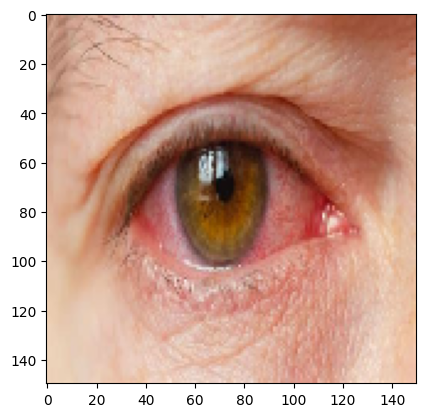

In [51]:
uploaded = files.upload()

for f in uploaded.keys():
  img = tf.keras.preprocessing.image.load_img(f, target_size=IMAGE_SIZE)

  plt.imshow(img)

  img = tf.keras.utils.img_to_array(img)
  img = tf.expand_dims(img, axis=0)

  prediction = model.predict(img)[0]

  print(f'Probability: {prediction}')
  print(f'Prediction: {CLASSES[np.argmax(prediction)]}')